In [1]:
import pypssl
import getpass

# Configure PassiveSSL credentials
PASSIVE_SSL_USER = getpass.getpass("PassiveSSL Username: ")
PASSIVE_SSL_KEY = getpass.getpass("PassiveSSL API Key: ")

pssl = pypssl.PyPSSL(basic_auth=(PASSIVE_SSL_USER, PASSIVE_SSL_KEY))

PassiveSSL Username:  ········
PassiveSSL API Key:  ········


In [3]:
ip_address = '8.8.8.8'

data = pssl.query(ip_address)

certificates_sha1 = set()

for cert in data[ip_address]["certificates"]:
    certificates_sha1.add(cert)


print(f"Found {len(certificates_sha1)} unique certificates for IP {ip_address}:")
for sha1 in sorted(certificates_sha1):
    print(sha1)

Found 6 unique certificates for IP 8.8.8.8:
2b1cfcc7a28761057b4916c7f531efefcea0694e
7359755c6df9a0abc3060bce369564c8ec4542a3
afc4b2ab726ba1be1a08a86fbde5c25bb38438c0
d6ad07c6675630f57b927f66be8ce1f768f87948
dfe2070c79e7ff36a925ffa327ffe3deecf8f9c2
e7ca3945dd93890e5fc3d02ea705aa70ae8bbaf5


Error processing afc4b2ab726ba1be1a08a86fbde5c25bb38438c0: Unable to decode JSON object: Not existing certificate
Error processing dfe2070c79e7ff36a925ffa327ffe3deecf8f9c2: Unable to decode JSON object: Not existing certificate


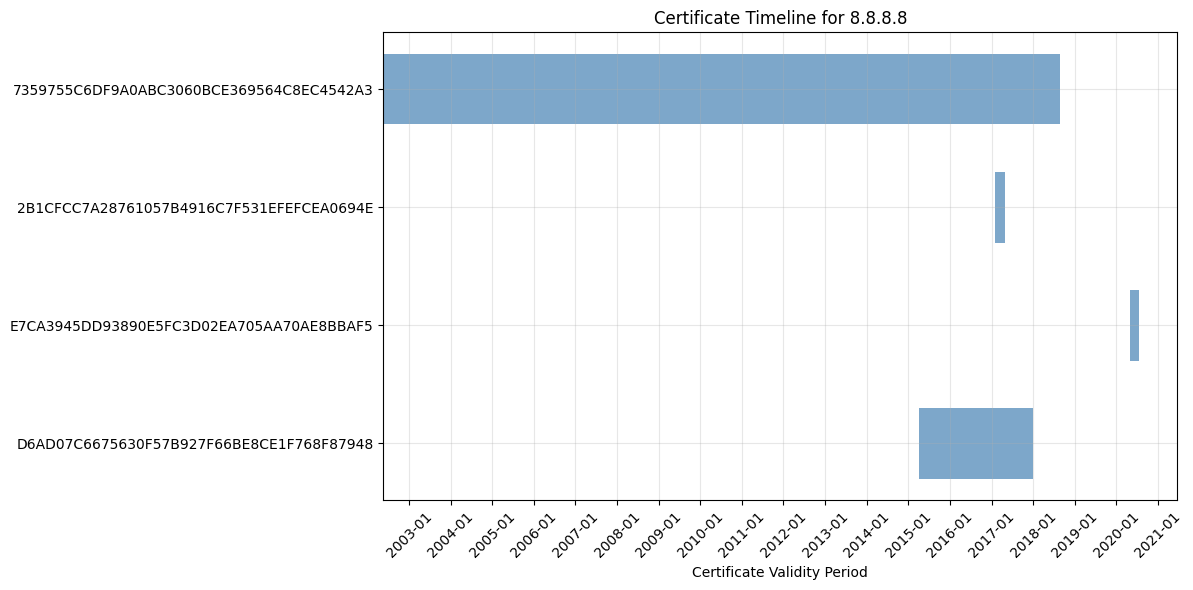

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

def check_expired_certs(cert_info):
    now = datetime.now(UTC)
    info = cert_info.get('info', {})
    
    not_after = info.get('not_after')
    fingerprint = info.get('fingerprint', 'N/A')
    
    if not_after and not_after < now:
        return (fingerprint, not_after)
    return None
    
timeline_data = []

for cert_sha1 in certificates_sha1:
    try:
        cert_info = pssl.fetch_cert(cert_sha1)
        info = cert_info.get('info', {})
        
        not_before = info.get('not_before')
        not_after = info.get('not_after')
        fingerprint = info.get('fingerprint', cert_sha1[:12])
        
        if not_before and not_after:
            timeline_data.append({
                'fingerprint': fingerprint,
                'not_before': not_before,
                'not_after': not_after
            })
    except Exception as ex:
        print(f"Error processing {cert_sha1}: {ex}")
    
if timeline_data:
    # Create timeline visualization
    fig, ax = plt.subplots(figsize=(12, max(6, len(timeline_data)*0.8)))
    
    dates_before = [mdates.date2num(x['not_before']) for x in timeline_data]
    dates_after = [mdates.date2num(x['not_after']) for x in timeline_data]
    durations = [after - before for before, after in zip(dates_before, dates_after)]
    
    y_pos = range(len(timeline_data))
    
    ax.barh(y_pos, durations, left=dates_before, height=0.6, 
            color='steelblue', alpha=0.7)
    
    ax.set_yticks(y_pos)
    ax.set_yticklabels([d['fingerprint'] for d in timeline_data])
    
    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    ax.set_xlabel('Certificate Validity Period')
    ax.set_title(f'Certificate Timeline for {ip_address}')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No valid certificate data found for timeline.")

In [10]:
from datetime import datetime
from datetime import timezone as tz

# Summary statistics for certificates
expired_count = 0
issuer_counts = {}
now = datetime.now(tz.utc)

for cert_sha1 in certificates_sha1:
    try:
        cert_info = pssl.fetch_cert(cert_sha1)
        info = cert_info.get('info', {})
        
        # Check expiration
        not_after = info.get('not_after')
        if not_after and not_after < now:
            expired_count += 1
        
        # Count issuers
        issuer = info.get('issuer', 'Unknown')
        issuer_counts[issuer] = issuer_counts.get(issuer, 0) + 1
    except Exception as ex:
        print(f"Error processing {cert_sha1}: {ex}")

# Print summary
print("\n" + "="*60)
print("CERTIFICATE SUMMARY")
print("="*60)
print(f"Total Certificates: {len(certificates_sha1)}")
print(f"Expired Certificates: {expired_count}")
print(f"\nUnique Issuers ({len(issuer_counts)}):")
for issuer, count in sorted(issuer_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {issuer}: {count}")
print("="*60 + "\n")

Error processing afc4b2ab726ba1be1a08a86fbde5c25bb38438c0: Unable to decode JSON object: Not existing certificate
Error processing dfe2070c79e7ff36a925ffa327ffe3deecf8f9c2: Unable to decode JSON object: Not existing certificate

CERTIFICATE SUMMARY
Total Certificates: 6
Expired Certificates: 4

Unique Issuers (4):
  C=US, O=GeoTrust Inc., CN=GeoTrust Global CA: 1
  C=US, O=Google Trust Services, CN=GTS CA 1O1: 1
  C=US, O=Google Inc, CN=Google Internet Authority G2: 1
  C=US, O=Equifax, OU=Equifax Secure Certificate Authority: 1

